## Firstly import all the required modules

In [1]:
import numpy as np
import pandas as pd
import nltk
import sklearn
import operator
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
from scipy.sparse import coo_matrix, hstack
from sklearn.tree import DecisionTreeClassifier
from string import punctuation

#### (If required) download the required nltk files

In [2]:
nltk.download('stopwords') # If needed. Could optionally define from scratch. 
nltk.download('punkt')
nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/charlie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/charlie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/charlie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Create various utility functions + custom tokeniser

In [3]:

def load_data(filename_pos: str, filename_neg: str, shuffle: bool = False):
    """Loads data into a combined pandas DataFrame. will randomly shuffle
    the rows if specified. DataFrame will have columns as such:
    ##################
    "review" | "sentiment"
    string   | int[0,1]
    ...
    ##################
    Where a 1 in the sentiment column indicates a negative review.
    """
    df_pos = pd.read_csv(filename_pos, sep="\n", header=None, names=['review'], encoding='utf8')
    df_pos['sentiment'] = 0  # 0 = positive
    df_neg = pd.read_csv(filename_neg, sep="\n", header=None, names=['review'], encoding='utf8')
    df_neg['sentiment'] = 1  # 1 = negative
    df = df_pos.append(df_neg)
    if shuffle:
        df = df.sample(frac=1, random_state=37).reset_index(drop=True)
    return df

class chi2_feature_selection:
    def __init__(self, X_training, Y_training, k_final_words):
        self.fs_sentanalysis = SelectKBest(chi2, k=k_final_words).fit(X_training, Y_training)
        
    def do_selection(self, X_data):
        X_data_chi2 = self.fs_sentanalysis.transform(X_data)
        print("Size original matrix: " + str(X_data.shape))
        print("Size new matrix: " + str(X_data_chi2.shape))
        return X_data_chi2


def get_score(Y_gold, Y_pred):
    precision = precision_score(Y_gold, Y_pred, average='macro')
    recall = recall_score(Y_gold, Y_pred, average='macro')
    f1 = f1_score(Y_gold, Y_pred, average='macro')
    accuracy = accuracy_score(Y_gold, Y_pred)
    print(f"Precision: {round(precision, 3)}")
    print(f"Recall: {round(recall, 3)}")
    print(f"F1-Score: {round(f1, 3)}")
    print(f"Accuracy: {round(accuracy, 3)}")
    return {"precision": precision,
            "recall": recall,
            "f1_score": f1,
            "accuracy": accuracy}


lemmatizer = nltk.stem.WordNetLemmatizer()
def my_tokenizer(document):  # custom tokenzier function
    """This will be ran *after* the built-in preprocessor
    which according to the docs by default just performs
    document.lower()"""
    tokens = document.split()  # split on whitespace
    # replace common punctuation with nothing
    translator = str.maketrans('','',punctuation)
    tokens = [token.translate(translator) for token in tokens]
    # lemmatize tokens
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # remove blank strings
    for i, token in enumerate(lemma_tokens):
        if token == '':
            del lemma_tokens[i]
    # remove strings of length one
    tokens = [token for token in tokens if len(token) > 1]
    return lemma_tokens

### Define stopwords set

Initially using the nltk built-in english stopwords, then adding in a customized list of stopwords - based on the output seen from the vectorizers later in this Notebook. E.g. the dataset includes some HTML tags like `<br>` which obviously aren't useful for sentiment analysis. 
Further note that the stopwords are ran though the tokenizng function to ensure they match the vectorized features later on. 

In [5]:
stopwords = set(nltk.corpus.stopwords.words('english'))
extra_stopwords = [".", ",", "--", "``", "''", "&", "!", "?", "'s", "n't", ";", "'", "-", "/", "<", ">", 
                   "br", "(", ")", "wa", "ha", "...", ":", "^", "`", "*", ""]
for stopword in extra_stopwords:
    stopwords.add(stopword)

stopwords = my_tokenizer(' '.join(stopwords))

## Load in datafiles

In [6]:
print("Loading data...")
train_set = load_data("IMDb/train/imdb_train_pos.txt", "IMDb/train/imdb_train_neg.txt", True)  # choo choo
dev_set = load_data("IMDb/dev/imdb_dev_pos.txt", "IMDb/dev/imdb_dev_neg.txt", True)
test_set = load_data("IMDb/test/imdb_test_pos.txt", "IMDb/test/imdb_test_neg.txt", True)
print("Done.")

Loading data...
Done.


## Build and refine each feature's vectors:
<ol>
    <li>Create standard TF-IDF Vectors</li>
    <li>Create TF-IDF bi-gram Vectors</li>
        <li>combine 1 and 2 and perform chi2 feature selection to narrow it down to the 100 most significant features</li>
    <li>Create character count Vectors - 1D vector so no selection required.</li>
    <li>Combine all vectors</li>
</ol>

### Create TF-IDF unigram vectors

In [7]:
# perform the TF-IDF count vectorization.
print("Calculating TF-IDF vectors...")
tfidf_1 = TfidfVectorizer(stop_words=stopwords, tokenizer=my_tokenizer, max_df=0.9, min_df=0.02)
tfidf_1.fit(train_set['review'], train_set['sentiment'])

X_train_tfidf_1 = tfidf_1.transform(train_set['review'])
X_dev_tfidf_1 = tfidf_1.transform(dev_set['review'])
X_test_tfidf_1 = tfidf_1.transform(test_set['review'])
print("Done!")
print(f"produced {len(np.asarray(tfidf_1.get_feature_names()))} features, top 50:\n{np.asarray(tfidf_1.get_feature_names())[:50]}")

Calculating TF-IDF vectors...
Done!
produced 843 features, top 50:
['1' '10' '2' '20' '3' '30' '4' '5' '70' '80' 'ability' 'able'
 'absolutely' 'accent' 'across' 'act' 'acted' 'acting' 'action' 'actor'
 'actress' 'actual' 'actually' 'add' 'admit' 'adult' 'adventure' 'age'
 'ago' 'agree' 'air' 'almost' 'alone' 'along' 'already' 'also' 'although'
 'always' 'amazing' 'america' 'american' 'among' 'amount' 'annoying'
 'another' 'anyone' 'anything' 'anyway' 'apart' 'apparently']


### Create bigram TF-IDF vectors

In [8]:
# Perform TF-IDF vectorization with bi-grams. 
print("Calculating TF-IDF bi-gram vectors...")
tfidf_2 = TfidfVectorizer(stop_words=stopwords, ngram_range=(2, 2), tokenizer=my_tokenizer, max_df=0.90, min_df=0.01)
tfidf_2.fit(train_set['review'], train_set['sentiment'])

X_train_tfidf_2 = tfidf_2.transform(train_set['review'])
X_dev_tfidf_2 = tfidf_2.transform(dev_set['review'])
X_test_tfidf_2 = tfidf_2.transform(test_set['review'])
print("Done!")
print(f"produced {len(np.asarray(tfidf_2.get_feature_names()))} features. ")

Calculating TF-IDF bi-gram vectors...
Done!
produced 135 features. 


In [9]:
# Combine above vectors
X_train_combi = hstack([X_train_tfidf_1, X_train_tfidf_2])

X_dev_combi = hstack([X_dev_tfidf_1, X_dev_tfidf_2])

X_test_combi = hstack([X_test_tfidf_1, X_test_tfidf_2])

#X_train_combi = X_train_tfidf_1
#X_dev_combi = X_dev_tfidf_1
#X_test_combi = X_test_tfidf_1

## Perform feature selection via SelectKBest using chi$^2$

In [10]:
k = 200
chi2_selector = chi2_feature_selection(X_train_combi, train_set["sentiment"], k)

X_train_chi2 = chi2_selector.do_selection(X_train_combi)
X_dev_chi2 = chi2_selector.do_selection(X_dev_combi)
X_test_chi2 = chi2_selector.do_selection(X_test_combi)

Size original matrix: (15000, 978)
Size new matrix: (15000, 200)
Size original matrix: (5000, 978)
Size new matrix: (5000, 200)
Size original matrix: (5000, 978)
Size new matrix: (5000, 200)


## Create a vector with the average sentence length and the word count of the reviews

Being a 2-dimension vector of hand-picked features I don't believe this requires any feature selection. 

In [11]:
# word count vector

X_train_chars, X_dev_chars, X_test_chars = [], [], []
for review in train_set["review"]:
    X_train_chars.append([np.mean([len(sent) for sent in review.split(".")]), np.mean(len(review.split(" ")))])
for review in dev_set["review"]:
    X_dev_chars.append([np.mean([len(sent) for sent in review.split(".")]), np.mean(len(review.split(" ")))])
for review in test_set["review"]:
    X_test_chars.append([np.mean([len(sent) for sent in review.split(".")]), np.mean(len(review.split(" ")))])
    
# np.mean([len(sent) for sent in review.split(".")]), 
# Scale to a range of 0 to 1 to match the TfidfVectorizer output
scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train_chars)
# Convert into sparse matrices to match as above
X_train_chars = coo_matrix(scaling.transform(X_train_chars))
X_dev_chars = coo_matrix(scaling.transform(X_dev_chars))
X_test_chars = coo_matrix(scaling.transform(X_test_chars))

In [12]:
# Combine into final input vectors

X_train_final = hstack([X_train_chi2, X_train_chars])
X_dev_final = hstack([X_dev_chi2, X_dev_chars])
X_test_final = hstack([X_test_chi2, X_test_chars])

print(f"Final dimensions of training data: {X_train_final.shape}")

Final dimensions of training data: (15000, 202)


## Train multiple classifiers with different settings
(These steps may take a while)

### Linear classifier

In [13]:
# Train Linear SVM Classifier
print("Beginning Linear SVM training...")
start = time.time()
svm_clf_lin = sklearn.svm.SVC(kernel='linear', gamma='auto')
svm_clf_lin_result = svm_clf_lin.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")

Beginning Linear SVM training...
Done! Time to train classifier was: 15.239 s


### Polynomial classifier - 3 degrees

In [14]:
# Train Poly SVM Classifier
print("Beginning Polynomial SVM training...")
start = time.time()

svm_clf_poly3 = sklearn.svm.SVC(kernel='poly', degree=3, coef0=1, gamma='auto')

svm_clf_poly3_result = svm_clf_poly3.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")


Beginning Polynomial SVM training...
Done! Time to train classifier was: 28.927 s


### Polynomial classifier - 6 degrees

In [15]:
# Train Poly SVM Classifier
print("Beginning Polynomial SVM training...")
start = time.time()

svm_clf_poly6 = sklearn.svm.SVC(kernel='poly', degree=6, coef0=1, gamma='auto')

svm_clf_poly6_result = svm_clf_poly6.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")


Beginning Polynomial SVM training...
Done! Time to train classifier was: 25.285 s


### Polynomial classifier - 10 degrees

In [16]:
# Train Poly SVM Classifier
print("Beginning Polynomial SVM training...")
start = time.time()

svm_clf_poly10 = sklearn.svm.SVC(kernel='poly', degree=10, coef0=1, gamma='auto')

svm_clf_poly10_result = svm_clf_poly10.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")


Beginning Polynomial SVM training...
Done! Time to train classifier was: 23.148 s


### Polynomial classifier - 15 degrees

In [17]:
# Train Poly SVM Classifier
print("Beginning Polynomial SVM training...")
start = time.time()

svm_clf_poly15 = sklearn.svm.SVC(kernel='poly', degree=15, coef0=1, gamma='auto')

svm_clf_poly15_result = svm_clf_poly15.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")


Beginning Polynomial SVM training...
Done! Time to train classifier was: 21.317 s


### RBF classifier

In [18]:
# Train RBF SVM Classifier
print("Beginning RBF SVM training...")
start = time.time()

svm_clf_rbf = sklearn.svm.SVC(kernel='rbf', gamma='auto')
svm_clf_rbf_result = svm_clf_rbf.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")

Beginning RBF SVM training...
Done! Time to train classifier was: 32.948 s


### Decision Tree

In [19]:
# Train Decision Tree
print("Beginning Decision Tree training...")
start = time.time()
dtree_clf = DecisionTreeClassifier(max_depth=4, random_state=37)
dtree_clf_result = dtree_clf.fit(X_train_final, train_set["sentiment"])
end = time.time()
print(f"Done! Time to train classifier was: {round(end - start, 3)} s")

Beginning Decision Tree training...
Done! Time to train classifier was: 0.133 s


## Make predictions from models

(Takes a few moments for each model)

In [20]:
dev_predictions = {}
dev_lin_pred = svm_clf_lin.predict(X_dev_final)
print("Linear SVM:\n------------")
dev_predictions.update( {"linear": get_score(dev_set["sentiment"], dev_lin_pred)} )

dev_poly3_pred = svm_clf_poly3.predict(X_dev_final)
print("\n3 degree Polynomial SVM:\n------------")
dev_predictions.update( {"poly3": get_score(dev_set["sentiment"], dev_poly3_pred)} )

dev_poly6_pred = svm_clf_poly6.predict(X_dev_final)
print("\n6 degree Polynomial SVM:\n------------")
dev_predictions.update( {"poly6": get_score(dev_set["sentiment"], dev_poly6_pred)} )

dev_poly10_pred = svm_clf_poly10.predict(X_dev_final)
print("\n10 degree Polynomial SVM:\n------------")
dev_predictions.update( {"poly10": get_score(dev_set["sentiment"], dev_poly10_pred)} )

dev_poly15_pred = svm_clf_poly15.predict(X_dev_final)
print("\n15 degree Polynomial SVM:\n------------")
dev_predictions.update( {"poly15": get_score(dev_set["sentiment"], dev_poly15_pred)} )

dev_rbf_pred = svm_clf_rbf.predict(X_dev_final)
print("\nRBF SVM:\n------------")
dev_predictions.update( {"RBF": get_score(dev_set["sentiment"], dev_rbf_pred)} )

dev_dtree_pred = dtree_clf.predict(X_dev_final)
print("\nDecision Tree:\n------------")
dev_predictions.update( {"Decision tree": get_score(dev_set["sentiment"], dev_dtree_pred)})

Linear SVM:
------------
Precision: 0.834
Recall: 0.834
F1-Score: 0.834
Accuracy: 0.834

3 degree Polynomial SVM:
------------
Precision: 0.792
Recall: 0.778
F1-Score: 0.776
Accuracy: 0.779

6 degree Polynomial SVM:
------------
Precision: 0.805
Recall: 0.797
F1-Score: 0.797
Accuracy: 0.798

10 degree Polynomial SVM:
------------
Precision: 0.814
Recall: 0.81
F1-Score: 0.809
Accuracy: 0.81

15 degree Polynomial SVM:
------------
Precision: 0.821
Recall: 0.818
F1-Score: 0.818
Accuracy: 0.818

RBF SVM:
------------
Precision: 0.777
Recall: 0.756
F1-Score: 0.752
Accuracy: 0.757

Decision Tree:
------------
Precision: 0.719
Recall: 0.664
F1-Score: 0.643
Accuracy: 0.666


### Plot results for different classifiers

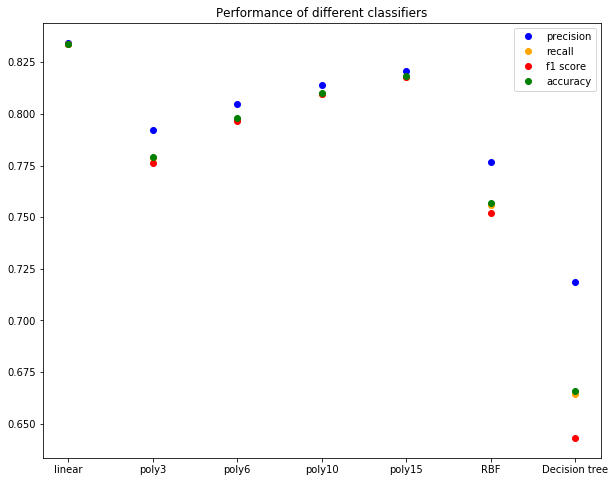

In [24]:
import matplotlib.pyplot as plt

my_xticks = [result for result in dev_predictions]
x = np.arange(len(dev_predictions))
plt.figure(figsize=(10,8))
plt.xticks(x, my_xticks)

y_precision = [dev_predictions[result]["precision"] for result in dev_predictions]
y_recall = [dev_predictions[result]["recall"] for result in dev_predictions]
y_f1 = [dev_predictions[result]["f1_score"] for result in dev_predictions]
y_accuracy = [dev_predictions[result]["accuracy"] for result in dev_predictions]

plt.plot(x, y_precision, marker='o', label="precision", color="blue", linestyle='none')
plt.plot(x, y_recall, marker='o', label="recall", color="orange", linestyle='none')
plt.plot(x, y_f1, marker='o', label="f1 score", color="red", linestyle='none')
plt.plot(x, y_accuracy, marker='o', label="accuracy", color="green", linestyle='none')
plt.title("Performance of different classifiers")
plt.legend()
plt.show()

## Test Data
From the above we can see that the <b>linear model</b> is the best in terms of both time to train and every single statistic for the development set. The 15 degree polynomial does come close, however. It might be worth setting up a way to test an extended range of polynomial degrees, however judging by the results above, increasing the degrees has a diminishing return and I suspect would begin to over-fit at some critical number. 

In [22]:
test_lin_pred = svm_clf_lin.predict(X_test_final)
print("Linear SVM:\n------------")
test_result = get_score(test_set["sentiment"], test_lin_pred)

tn, fp, fn, tp = confusion_matrix(test_set["sentiment"], test_lin_pred).ravel()
print(f"True Negative: {tn}\tFalse Positive: {fp}\nFalse Negative: {fn}\tTrue Positive: {tp}")

Linear SVM:
------------
Precision: 0.842
Recall: 0.841
F1-Score: 0.841
Accuracy: 0.841
True Negative: 2163	False Positive: 336
False Negative: 459	True Positive: 2042
